In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [0]:
from keras import backend as K
from keras.layers import Layer
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization

In [3]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

Saving kaggle.json to kaggle.json


In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [0]:
get_data(competition_name)

In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [12]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


# **Visualize**

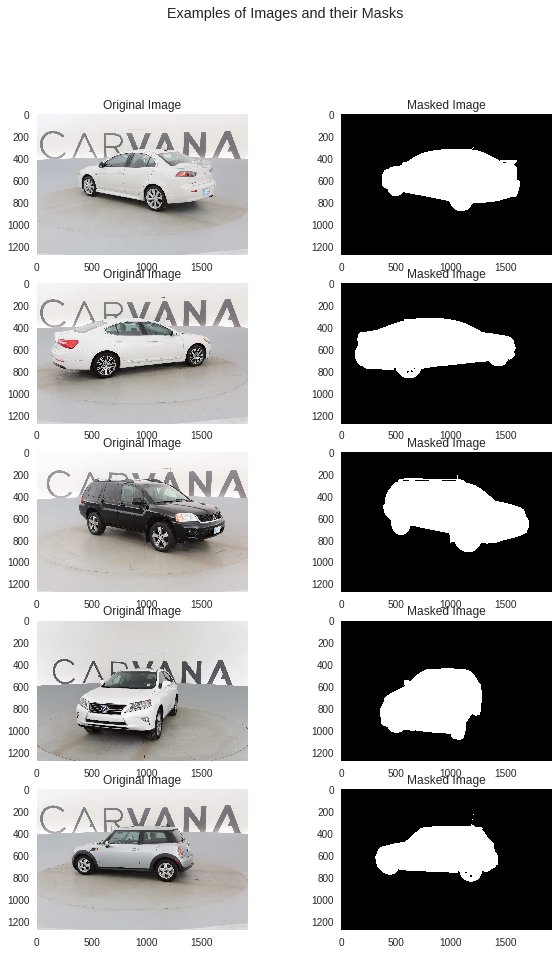

In [13]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5


# Processing each **pathname**

In [0]:
def _process_pathnames(fname, label_path):
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_gif(label_img_str)[0]
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

# Shifting the **image**

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

# Flipping the image **randomly**

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# **Assembling our transformations into our augment function**

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  dataset = dataset.repeat().batch(batch_size)
  return dataset

# **Set up train and validation datasets**

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)


In [22]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


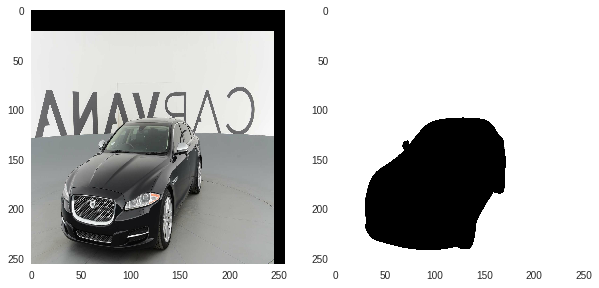

In [23]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

# **Build the model**

In [0]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = K.tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    K.tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [0]:
def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)
    
    conv_1 = Conv2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)
    conv_5 = Conv2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)
    conv_8 = Conv2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)
    conv_11 = Conv2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    conv_14 = Conv2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])
    conv_17 = Conv2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])
    conv_20 = Conv2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])
    conv_23 = Conv2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])
    conv_25 = Conv2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
            (input_shape[0]*input_shape[1], n_labels),
            input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [122]:
model = segnet(img_shape, 384)

Build enceder done..
Build decoder done..


# **Compile**

In [123]:
from keras.optimizers import SGD

optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 256, 256, 64) 256         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 256, 256, 64) 0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_46 

In [0]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size)))
                   )